 <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Beta distributions on election data

_Authors: Joseph Nelson (DC)_

---

## Dataset

In this lab you will be looking at [election data taken from Andrew Gelman's book on Bayesian statistics](http://www.stat.columbia.edu/~gelman/arm/examples/election88/) (highly recommended!).

You are required to perform a bit of feature engineering.

The data contains polling information for George H.W. Bush as well as election information. 

The polling information indicates samples by state of who intends to vote for Bush or not. The voting information is a sample after the election asking who actually voted for bush or not.


### 1. Import and parse the data

There are two datasets:

    election88  :  this contains the election voting poll information
    pre_poll    :  this contains the pre-election voting poll information
    
Remove DC, AK, and HI from the election datasets.

In [1]:
import pandas as pd
import numpy as np

In [2]:
election88 = pd.read_csv('../datasets/election88.csv')

election88.rename(columns={'stnum':'state_id','samplesize':'vote_total'}, inplace=True)

election88[election88.isnull().T.any()]

,Unnamed: 0,state_id,st,electionresult,vote_total,raking,_merge
1,2,2,AK,0.60,0,NaN,1
8,9,9,DC,0.14,19,NaN,1
11,12,12,HI,0.45,0,NaN,1


In [3]:
election88.dropna(inplace=True)

print(election88.shape)
election88.head(3)

(48, 7)


,Unnamed: 0,state_id,st,electionresult,vote_total,raking,_merge
0,1,1,AL,0.59,203,0.673067,3
2,3,3,AZ,0.60,194,0.568980,3
3,4,4,AR,0.56,121,0.563672,3


In [4]:
# Reading in the poll csv file
pre_poll = pd.read_csv('../datasets/polls.csv')

# remove unneccessary columns:
pre_poll.drop(['org'], axis=1, inplace=True)

pre_poll.rename(columns={'state':'state_id'}, inplace=True)

pre_poll = pre_poll.merge(election88[['state_id','st']], on='state_id')

print(pre_poll.shape)
pre_poll.head(3)

(13525, 11)


,Unnamed: 0,year,survey,bush,state_id,edu,age,female,black,weight,st
0,1,1,9152,1.0,7,2,2,1,0,1403,CT
1,30,1,9152,1.0,7,4,3,1,0,701,CT
2,206,1,9152,0.0,7,2,1,0,0,4341,CT


In [5]:
# print state category counts
print(pre_poll['st'].value_counts())

CA    1493
NY     894
TX     788
FL     750
PA     616
OH     605
IL     567
MI     530
NJ     428
WA     393
WI     389
MA     373
VA     354
NC     346
TN     329
GA     316
MO     309
IN     291
MN     289
MD     284
SC     223
MS     220
KY     210
AL     203
LA     196
AZ     194
CO     181
CT     171
OR     149
IA     143
KS     141
OK     130
NE     125
AR     121
WV     117
NM     109
RI      91
UT      79
ND      60
SD      60
ME      51
ID      42
MT      40
DE      39
NV      32
NH      27
WY      15
VT      12
Name: st, dtype: int64


### 2. With the poll data, compute the number of people who did and didn't intend to vote for Bush by state.

In [6]:
def percent_bush_state(df):
    df = df[~df.bush.isnull()]
    df['poll_vote_bush'] = np.sum(df.bush)
    df['poll_vote_total'] = df.shape[0]
    df = df[['poll_vote_bush','poll_vote_total','st']]
    df.drop_duplicates(inplace=True)
    return df

state_bushpct_poll = pre_poll.groupby(['st']).apply(percent_bush_state).reset_index(drop=True)
state_bushpct_poll.head(3)

,poll_vote_bush,poll_vote_total,st
0,113.0,159,AL
1,59.0,101,AR
2,99.0,168,AZ


### 3. With the vote data, compute the number of people who did and didn't vote for Bush by state.

In [7]:
election88['vote_bush'] = np.around((election88.electionresult*election88.vote_total).values)
election88.head(5)

,Unnamed: 0,state_id,st,electionresult,vote_total,raking,_merge,vote_bush
0,1,1,AL,0.59,203,0.673067,3,120.0
2,3,3,AZ,0.60,194,0.568980,3,116.0
3,4,4,AR,0.56,121,0.563672,3,68.0
4,5,5,CA,0.51,1493,0.531725,3,761.0
5,6,6,CO,0.53,181,0.599325,3,96.0


### 4. Merge the poll and vote data together by state

In [8]:
state_poll_vs_result = state_bushpct_poll.merge(election88[['st','vote_bush','vote_total']], on='st')
state_poll_vs_result.head(3)

,poll_vote_bush,poll_vote_total,st,vote_bush,vote_total
0,113.0,159,AL,120.0,203
1,59.0,101,AR,68.0,121
2,99.0,168,AZ,116.0,194


### 5. Write a function to plot Beta probability distributions based on poll and vote counts.

The distributions should be on the same chart.

In [9]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

In [10]:
def poll_vote_betas(vote_a, vote_b, poll_a, poll_b, post_a, post_b, state):

    plt.figure(figsize=(6,5))
    pr = np.linspace(0.001, 0.999, 1000)
    
    # vote beta:
    plt.plot(pr, beta.pdf(pr, vote_a, vote_b), lw=3, c='darkred', label='vote')
    
    # poll beta:
    plt.plot(pr, beta.pdf(pr, poll_a, poll_b), lw=3, c='steelblue', label='poll')
    
    # posterior based on vote data and poll prior
    plt.plot(pr, beta.pdf(pr, alpha_post, beta_post), lw=3, c='green', label='posterior')
    
    # poll beta:
    plt.title(state+' poll vs. vote beta distributions', fontsize=20)
    plt.xlabel('probability density', fontsize=16)
    plt.ylabel('P(bush)', fontsize=16)
    
    plt.legend(loc='upper left', fontsize=14)

    plt.show()

### 6. Select 4 states of your choice and plot the beta distributions.

In [11]:
state = 'AL'
row = state_poll_vs_result[state_poll_vs_result.st==state]

alpha_poll = row.poll_vote_bush + 1
beta_poll = row.poll_vote_total - row.poll_vote_bush + 1

alpha_vote = row.vote_bush + 1
beta_vote = row.vote_total - row.vote_bush + 1

alpha_post = row.vote_bush + alpha_poll
beta_post = row.vote_total - row.vote_bush + beta_poll

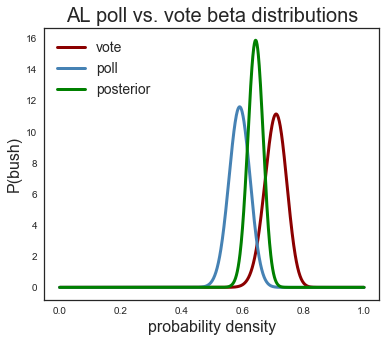

In [13]:
poll_vote_betas(alpha_poll, beta_poll, alpha_vote, beta_vote, alpha_post, beta_post, 'AL')